<h2><center>Аналитика в Яндекс.Афише</center></h2>

## Оглавление
* [Описание проекта](#first-bullet)
* [Описание данных](#second-bullet)
* [Шаг 1. Предобработка данных](#third-bullet)
* [Шаг 2. Построим отчёты и посчитаем метрики](#fourth-bullet)
* [Выводы](#fifth-bullet)

## Описание проекта <a class="anchor" id="first-bullet"></a>

Работа в отделе аналитики Яндекс.Афиши. Нужно помочь маркетологам оптимизировать маркетинговые затраты.

В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Нужно изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

## Описание данных <a class="anchor" id="second-bullet"></a>

#### Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


#### Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа


#### Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Шаг 1. Предобработка данных <a class="anchor" id="third-bullet"></a>

#### Импортируем все библиотеки, необходимые для работы:

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

#### Посмотрим на предоставленные данные:

In [3]:
visits = pd.read_csv('visits_log.csv')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


В таблице visits нет пропущенных значений, единственное, что хочется здесь исправить - это тип данных для Start Ts (дата и время начала сессии) и End Ts (дата и время окончания сессии), сейчас он распознался как тип object, но для дальнейших вчислений удобнее будет иметь тип datetime.


In [5]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Также приведем все названия столбцов таблицы visits к нижнему регистру.

In [6]:
visits.columns = map(str.lower, visits.columns)
visits.columns

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

In [7]:
orders = pd.read_csv('orders_log.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [8]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


В таблице orders тоже поменяем тип данных столбца Buy Ts (дата и время заказа) на datetime.

In [9]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


И приведем все названия столбцов к нижнему регистру.

In [10]:
orders.columns = map(str.lower, orders.columns)
orders.columns

Index(['buy ts', 'revenue', 'uid'], dtype='object')

In [11]:
costs = pd.read_csv('costs.csv')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [12]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


И в таблице costs сделаем тоже самое со столбцом dt(дата) - переведем его в тип datetime.

In [13]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Вывод

Были изучены данные о посещениях сайта, заказах и затратах на маркетинг. Во всех таблицах был заменен тип данных у столбцов с датами, а также в таблице visits и orders названия столбцов были приведены к нижнему регистру.

## Шаг 2. Построим отчёты и посчитаем метрики <a class="anchor" id="fourth-bullet"></a>

### 2.1 Продукт
- 2.1.1 Сколько людей пользуются в день, неделю, месяц?
- 2.1.2 Сколько сессий в день?
- 2.1.3 Сколько длится одна сессия?
- 2.1.4 Как часто люди возвращаются?

Чтобы ответить на эти вопросы воспользуемся данными из таблицы visits.

##### - 2.1.1 Сколько людей пользуются в день, неделю, месяц?

Найдем DAU, WAU, MAU продукта. Для этого сначала выделим день, неделю, месяц и год из даты начала сессии.

In [14]:
visits['session_year']  = visits['start ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start ts'].astype('datetime64[M]')
visits['session_week']  = visits['start ts'].astype('datetime64[W]')
visits['session_date'] = visits['start ts'].astype('datetime64[D]')

In [15]:
#visits['session_year']  = visits['start ts'].dt.year
#visits['session_month'] = visits['start ts'].dt.month
#visits['session_week']  = visits['start ts'].dt.week
#visits['session_date'] = visits['start ts'].dt.date

In [16]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
print('DAU (daily active users) = {}'.format(int(dau)))
print('WAU (weekly active users) = {}'.format(int(wau)))
print('MAU (monthly active users) = {}'.format(int(mau)))

DAU (daily active users) = 907
WAU (weekly active users) = 5621
MAU (monthly active users) = 23228


Средние значения найдены, теперь посмотрим на изменение DAU, WAU, MAU во времени в разрезе устройств.

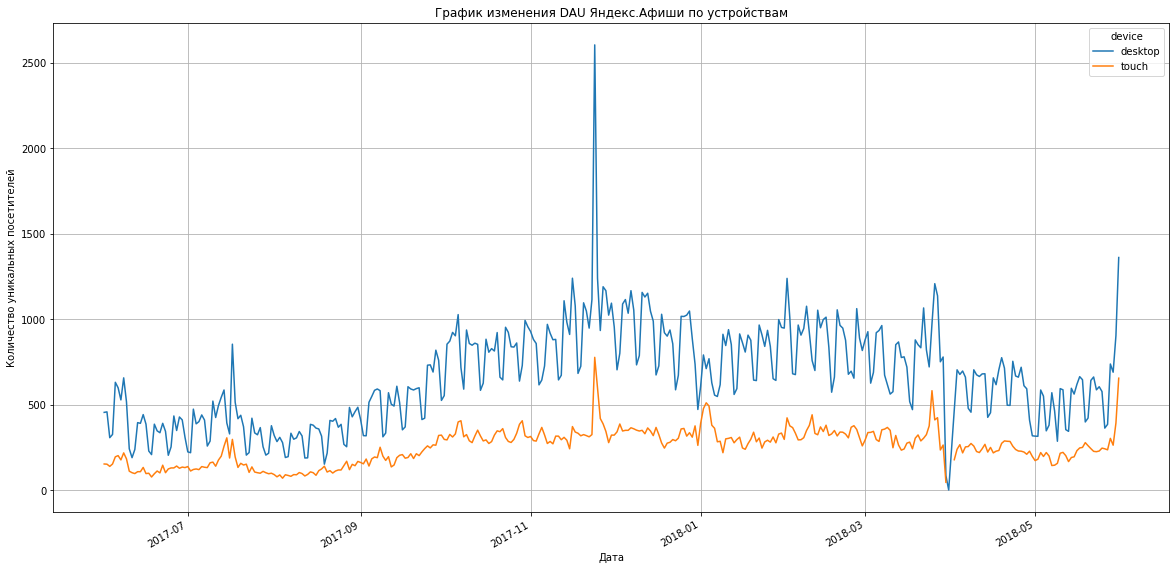

In [17]:
visits.pivot_table(index = 'session_date', columns = 'device', values = 'uid', aggfunc = 'nunique').plot(grid = True, figsize = (20,10))
plt.title('График изменения DAU Яндекс.Афиши по устройствам')
plt.ylabel('Количество уникальных посетителей')
plt.xlabel('Дата')
plt.show()

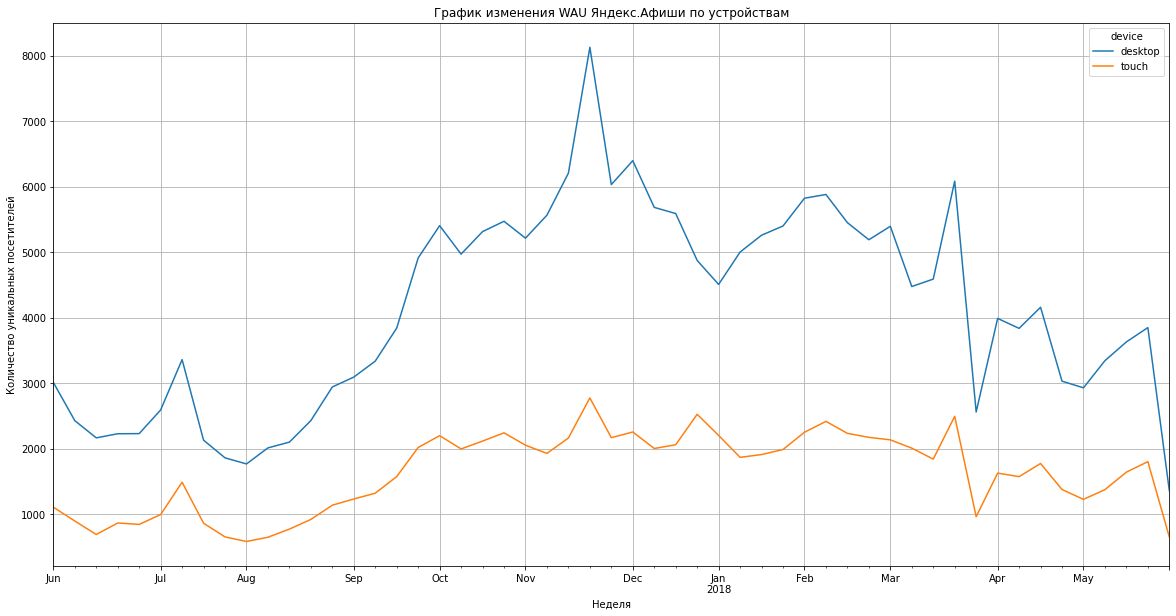

In [18]:
visits.pivot_table(index = ['session_week'], columns = 'device', values = 'uid', aggfunc = 'nunique').plot(grid = True, figsize = (20,10))
plt.title('График изменения WAU Яндекс.Афиши по устройствам')
plt.ylabel('Количество уникальных посетителей')
plt.xlabel('Неделя')
plt.show()

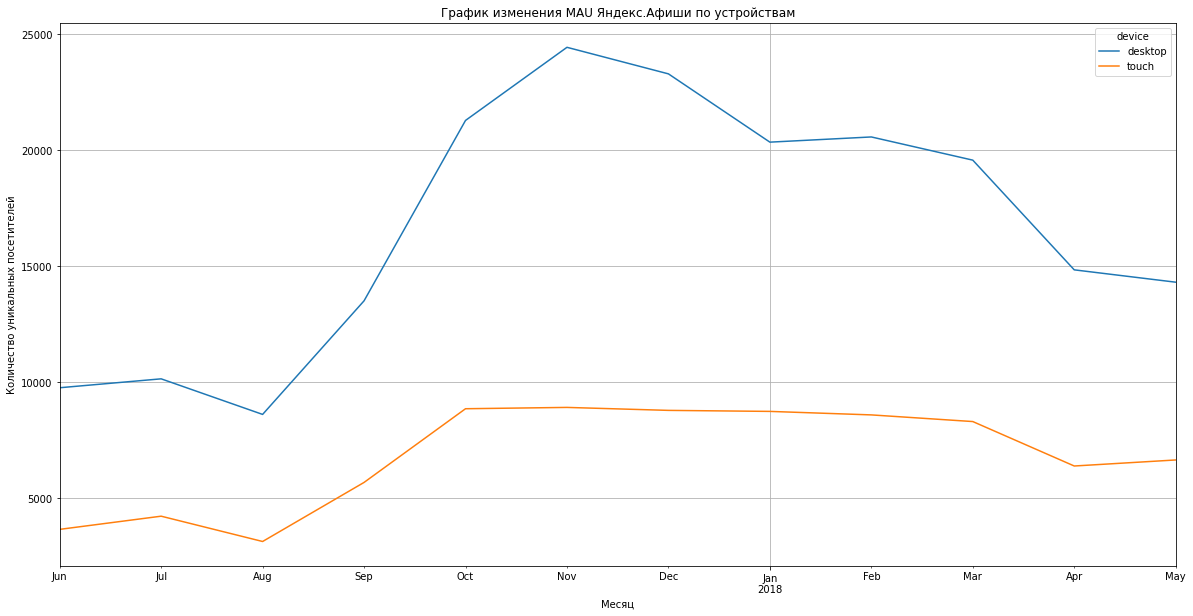

In [19]:
visits.pivot_table(index = ['session_month'], columns = 'device', values = 'uid', aggfunc = 'nunique').plot(grid = True, figsize = (20, 10))
plt.title('График изменения MAU Яндекс.Афиши по устройствам')
plt.ylabel('Количество уникальных посетителей')
plt.xlabel('Месяц')
plt.show()

Из графиков изменения DAU, WAU и MAU видно, что меньше всего посещений сайта происходит с июня по август - предполагаю потому, что люди в это время чаще чем обычно бывают в отпусках. Небольшой пик, появившийся в середине июля скорее всего можно обусловить каким-либо большим и давно ожидаемым концертом/мероприятием или скидками на сайте (то есть рекламной акцией, привлекшей много посетителей в один из дней/неделю июля). С сентября число посетителей начинает заметно расти и достигает пика где-то за неделю до первых чисел декабря - опять же, можно предположить, что это происходит потому, что в холодное время года люди больше хотят ходить на культурные мероприятия, чем в жару, а пик прям перед декабрем обусловлен покупкой большого кол-ва подарков на корпоративы (которые будут проводиться в декабре) или опять же - акцией. К концу декабря кол-во посетителей немного падает, но в целом остается похожим (500-1100 посетителей ежедневно) до конца марта. В конце марта 2018 наблюдается сильный провал в посещениях, пик графика уходит в ноль, так что можно предположить, что на 1-2 дня на сайте были какие-то серьезные технические неполадки (или что-то случилось с системой аналитики сайта). С апреля статистика восстанавливается, но общее число посетителей снижается (опять же можно предположить, что у сайта есть сезонность, в апреле становится теплее и людям меньше приходится думать о том как проводить свой досуг - они чаще проводят время на улице).

Также, если посмотреть на различия показателей DAU, WAU и MAU по устройствам, то мы видим, что тенденции между desktop и touch устройствами довольно похожие (пики и провалы примерно в одних и тех же сестах), но при этом посетителей с desktop приблизительно в 4 раза больше, чем с touch устройств и пики у desktop выделяются гораздо сильнее. </div>

 ##### - 2.1.2 Сколько сессий в день?
 
 Найдем сколько в среднем сессий в день приходится на одного пользователя.

Это можно сделать с помощью таблицы:

In [20]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


Или посчитать число:

In [21]:
float(visits.groupby(['uid', 'session_date']).agg({'start ts': 'count'}).mean())
print('Среднее кол-во сессий на одного пользователя в день: {}'.format(float(visits.groupby(['uid', 'session_date']).agg({'start ts': 'count'}).mean())))

Среднее кол-во сессий на одного пользователя в день: 1.0874136559064957


Теперь посмотрим на те же данные, но с разбивкой по устройствам:

In [22]:
sessions_per_user_per_device = visits.groupby(['session_date', 'device']).agg({'uid': ['count','nunique']})
sessions_per_user_per_device.columns = ['n_sessions', 'n_users']
sessions_per_user_per_device['sessions_per_user'] = sessions_per_user_per_device['n_sessions'] / sessions_per_user_per_device['n_users']
sessions_per_user_per_device

n_sessions  n_users  sessions_per_user
session_date device                                         
2017-06-01   desktop         501      455           1.101099
             touch           163      153           1.065359
2017-06-02   desktop         498      458           1.087336
             touch           160      152           1.052632
2017-06-03   desktop         329      307           1.071661
...                          ...      ...                ...
2018-05-29   touch           284      263           1.079848
2018-05-30   desktop         989      904           1.094027
             touch           421      393           1.071247
2018-05-31   desktop        1544     1361           1.134460
             touch           712      655           1.087023

[727 rows x 3 columns]

Построим наглядный график:

In [23]:
visits.head

<bound method NDFrame.head of          device              end ts  source id            start ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid session_year session_month session_week  \
0       16879256277535980062   2017-01-01    2017-12-01  

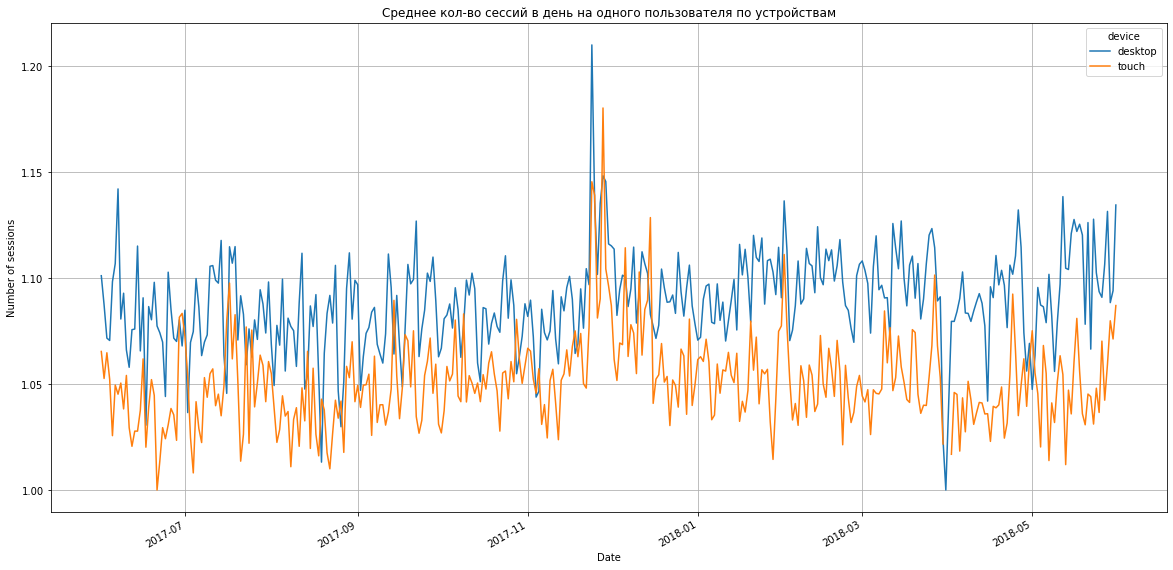

In [24]:
sessions_per_user_per_device.pivot_table(index = 'session_date', columns = 'device', values = 'sessions_per_user', aggfunc = 'mean').plot(grid = True, figsize = (20, 10))
plt.title('Среднее кол-во сессий в день на одного пользователя по устройствам')
plt.ylabel('Number of sessions')
plt.xlabel('Date')
plt.show()

Из графика видно, что кол-во сессий все равно колеблется в районе единицы, но среднее количество сессий с desktop почти всегда выше среднего кол-ва сессий с touch устройств.

##### - 2.1.3 Сколько длится одна сессия?

Найдем сколько в среднем длится одна сессия пользователя. Для этого добавим в табицу visits новый столбец - session_duration.

In [25]:
visits['session_duration'] = ((visits['end ts'] - visits['start ts']).dt.seconds)/60

In [26]:
print('В среднем одна сессия длится {} минут.'.format(visits['session_duration'].mean()))

В среднем одна сессия длится 10.725108143201632 минут.


Построим гистограмму и добавим разбивку по устройствам.

array([<AxesSubplot:title={'center':'Длительность сессий на desktop'}, xlabel='Time, minutes', ylabel='Number of users'>,
       <AxesSubplot:title={'center':'Длительность сессий на touch'}, xlabel='Time, minutes', ylabel='Number of users'>],
      dtype=object)

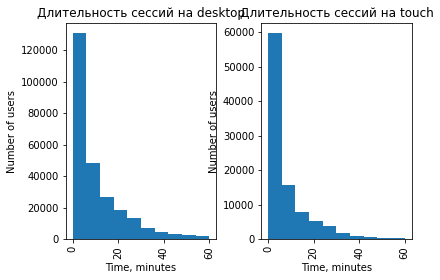

In [27]:
session_duration_hist = visits.hist('session_duration', bins = 10, by = 'device', range = (0, 60))


session_duration_hist[0].set_xlabel("Time, minutes")
session_duration_hist[0].set_ylabel("Number of users")
session_duration_hist[0].set_title("Длительность сессий на desktop")

session_duration_hist[1].set_xlabel("Time, minutes")
session_duration_hist[1].set_ylabel("Number of users")
session_duration_hist[1].set_title("Длительность сессий на touch")

session_duration_hist

Тк распределение не похоже на нормальное, то посчитаем также моду (наиболее часто встречающееся значение):

In [28]:
int(visits['session_duration'].mode())

1

Большинство сессий лятся 1-5 минут, но при этом есть сессии, длящиеся около 40-60 минут, которые смещают среднее в большую сторону. Из гистограмм видно, что среднее время на сайте не сильно отличается от того с какого устройства пришел пользователь.

##### - 2.1.4 Как часто люди возвращаются?

Для каждого пользователя найдем дату и время его первой сессии на сайте.

In [29]:
first_activity_date = visits.groupby(['uid'])['start ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.merge(first_activity_date, on='uid')
visits.head(10)

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00
5,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0.0,2017-12-27 14:06:00
6,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00
7,desktop,2017-10-27 16:02:00,3,2017-10-27 15:20:00,16007536194108375387,2017-01-01,2017-10-01,2017-10-26,2017-10-27,42.0,2017-09-03 21:35:00
8,desktop,2017-09-04 17:56:00,4,2017-09-04 17:37:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-04,19.0,2017-09-03 21:35:00
9,desktop,2017-10-28 00:04:00,3,2017-10-27 23:56:00,16007536194108375387,2017-01-01,2017-10-01,2017-10-26,2017-10-27,8.0,2017-09-03 21:35:00


In [30]:
visits['activity_month'] = visits['start ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

visits.head()

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date,activity_month,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01


In [31]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')
visits.head()

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,18.0,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,28.0,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


In [32]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime', 'device']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_activity_month,cohort_lifetime,device,uid
0,2017-06-01,0,desktop,9761
1,2017-06-01,0,touch,3655
2,2017-06-01,1,desktop,833
3,2017-06-01,1,touch,241
4,2017-06-01,2,desktop,593
...,...,...,...,...
151,2018-04-01,0,touch,4991
152,2018-04-01,1,desktop,553
153,2018-04-01,1,touch,220
154,2018-05-01,0,desktop,10252


In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid','device']]
initial_users_count.head()

,first_activity_month,uid,device
0,2017-06-01,9761,desktop
1,2017-06-01,3655,touch
24,2017-07-01,9312,desktop
25,2017-07-01,3982,touch
46,2017-08-01,7450,desktop


In [34]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count.head()

,first_activity_month,cohort_users,device
0,2017-06-01,9761,desktop
1,2017-06-01,3655,touch
24,2017-07-01,9312,desktop
25,2017-07-01,3982,touch
46,2017-08-01,7450,desktop


In [35]:
cohorts = cohorts.merge(initial_users_count,on=['first_activity_month', 'device'])
cohorts.head()

,first_activity_month,cohort_lifetime,device,uid,cohort_users
0,2017-06-01,0,desktop,9761,9761
1,2017-06-01,1,desktop,833,9761
2,2017-06-01,2,desktop,593,9761
3,2017-06-01,3,desktop,671,9761
4,2017-06-01,4,desktop,741,9761


In [36]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [37]:
cohorts_desktop = cohorts[cohorts['device'] == 'desktop']
cohorts_touch = cohorts[cohorts['device'] == 'touch']

In [38]:
retention_pivot_desktop = cohorts_desktop.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot_desktop

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.085340,0.060752,0.068743,0.075914,0.081856,0.067206,0.064235,0.058805,0.056552,0.045180,0.048253
2017-07-01,1.0,0.060997,0.055842,0.060997,0.064648,0.051869,0.050043,0.049721,0.041989,0.031035,0.028458,NaN
2017-08-01,1.0,0.080940,0.066040,0.067651,0.054497,0.046846,0.037450,0.040537,0.031409,0.029262,NaN,NaN
2017-09-01,1.0,0.088263,0.074691,0.055911,0.041400,0.042254,0.038412,0.025779,0.023816,NaN,NaN,NaN
2017-10-01,1.0,0.082922,0.055011,0.040106,0.036909,0.035012,0.022926,0.022384,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.080431,0.044811,0.040042,0.033832,0.024293,0.022405,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.052654,0.038353,0.030607,0.020098,0.020098,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.062117,0.040357,0.026124,0.021317,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.060118,0.026819,0.020018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


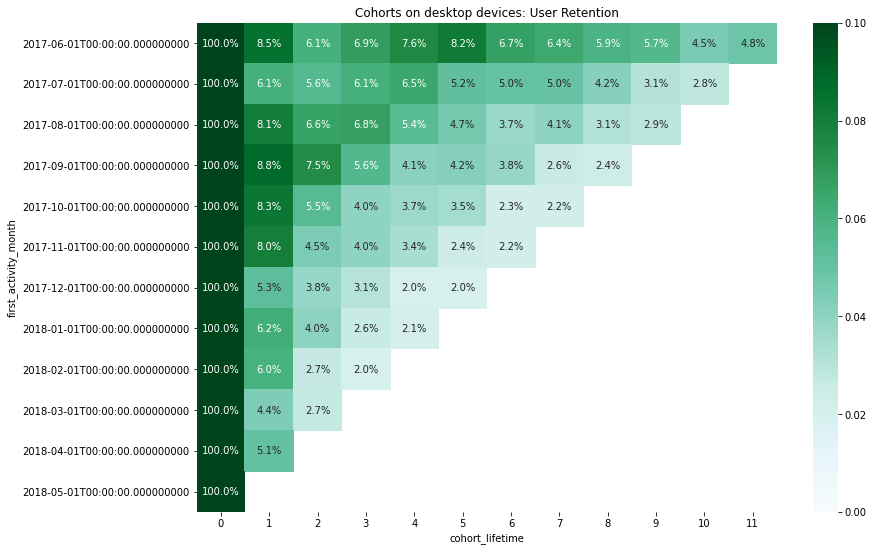

In [39]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts on desktop devices: User Retention')
sns.heatmap(retention_pivot_desktop, annot=True, fmt='.1%', vmin = 0.0,vmax = 0.1,cmap = 'BuGn');
plt.show()


#### Из тепловой карты по desktop устройствам видно, что:
- через месяц после первого посещения возвращается не больше 8,8% пользователей (сентябрь 2017),
- коэффициент удержания пользователей чаще всего снижается от месяца к месяцу, но иногда немного растет,
- когорта июня 2017 года изначально имела один из самых высоких коэффициентов удержания пользователей, но она также сохраняет его довольно высоким и через 11 месяцев (4,5-4,8%) - возможно стоит обратить внимание на то что было сделано в июне 2017 (или чуть раньше) для удержания пользователей - судя по всему это был удачный кейс

In [40]:
retention_pivot_touch = cohorts_touch.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot_touch

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.065937,0.039672,0.047332,0.058550,0.055267,0.054993,0.045964,0.042681,0.042955,0.034473,0.042681
2017-07-01,1.0,0.047966,0.043697,0.048970,0.047966,0.044450,0.037670,0.037921,0.034907,0.024611,0.027373,NaN
2017-08-01,1.0,0.071173,0.057582,0.055436,0.040773,0.040057,0.035408,0.039700,0.019671,0.019671,NaN,NaN
2017-09-01,1.0,0.084941,0.061562,0.044224,0.037210,0.031560,0.032340,0.020456,0.021625,NaN,NaN,NaN
2017-10-01,1.0,0.073376,0.049045,0.037325,0.030701,0.027643,0.018344,0.016051,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.077747,0.044962,0.036398,0.035461,0.021410,0.020206,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.066620,0.038451,0.033380,0.020141,0.016901,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.058421,0.038757,0.022514,0.018524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.052447,0.022561,0.020803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


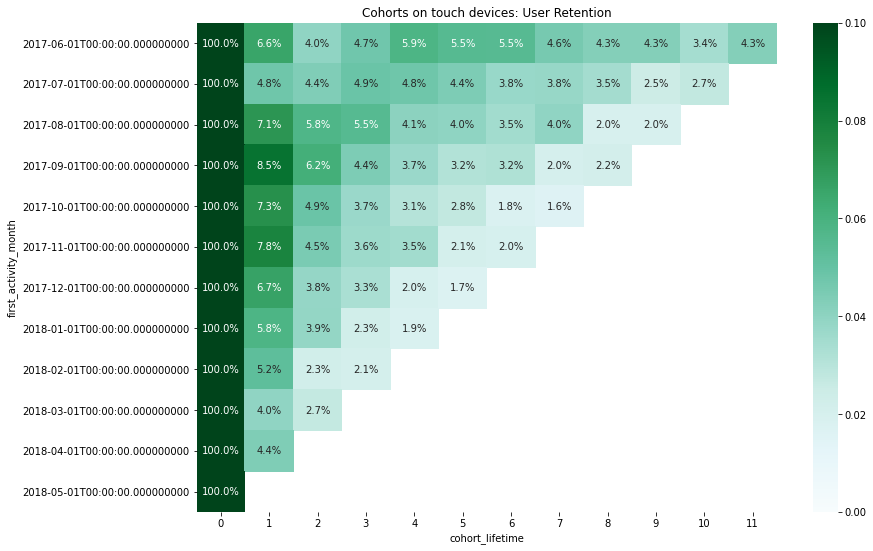

In [41]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts on touch devices: User Retention')
sns.heatmap(retention_pivot_touch, annot=True, fmt='.1%', vmin = 0.0,vmax = 0.1,cmap = 'BuGn');
plt.show()

#### Из тепловой карты по touch устройствам видно, что:
- через месяц после первого посещения возвращается не больше 8,5% пользователей (тоже в сентябре 2017),
- коэффициент удержания пользователей чаще всего снижается от месяца к месяцу, но иногда немного растет,
- когорта июня 2017 года изначально имела один из самых высоких коэффициентов удержания пользователей, но она также сохраняет его довольно высоким и через 11 месяцев (3.4 - 4,3%) - также как и с desktop устройствами - возможно стоит обратить внимание на то что было сделано в июне 2017 (или чуть раньше) для удержания пользователей

### 2.2 Продажи
- 2.2.1 Когда люди начинают покупать?
- 2.2.2 Сколько раз покупают за период?
- 2.2.3 Какой средний чек?
- 2.2.4 Сколько денег приносят? (LTV)

##### - 2.2.1 Когда люди начинают покупать?

То есть через какое время в среднем после первого посещения сайта пользователи совершают первую покупку.

В предыдущих шагах мы уже нашли время первого визита сайта для каждого пользователя - столбец first_activity_date в таблице visits.
Теперь аналогично найдем время и дату первой покупки для каждого пользователя - first_order_date в таблице orders.
После чего - объединим данные этих таблиц по уникальному идентификатору пользователя (Uid).

In [42]:
first_order_date = orders.groupby(['uid'])['buy ts'].min()
first_order_date.name = 'first_order_date'
orders = orders.merge(first_order_date, on='uid')
orders.head(10)

,buy ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:54:00
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00


Соединим таблицу visits и orders.

In [43]:
data = visits.merge(orders, on='uid')
data.head()

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date,activity_month,first_activity_month,cohort_lifetime,buy ts,revenue,first_order_date
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00


Добавим в таблицу столбец time_to_order, содержащий время от первого посещения сайта до первой покупки.

In [44]:
data['time_to_order'] = data['first_order_date'] - data['first_activity_date']
data.head()

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date,activity_month,first_activity_month,cohort_lifetime,buy ts,revenue,first_order_date,time_to_order
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,0 days 00:20:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,0 days 00:20:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,0 days 15:11:00
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,0 days 15:11:00
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,0 days 15:11:00


Переведем столбец с временем до первого заказа в часы:

In [45]:
data['time_to_order'] = data['time_to_order'].dt.total_seconds()/60/60
data.head()

,device,end ts,source id,start ts,uid,session_year,session_month,session_week,session_date,session_duration,first_activity_date,activity_month,first_activity_month,cohort_lifetime,buy ts,revenue,first_order_date,time_to_order
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,24.0,2018-03-09 20:05:00,2018-05-01,2018-03-01,2,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,0.333333
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,28.0,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,0.333333
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,15.183333
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,15.183333
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,1.0,2017-09-03 21:35:00,2017-09-01,2017-09-01,0,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,15.183333


In [46]:
data['time_to_order'].describe()

count    761807.000000
mean        423.617258
std        1016.850158
min           0.000000
25%           0.283333
50%          47.816667
75%         213.116667
max        8719.066667
Name: time_to_order, dtype: float64

In [47]:
(data['time_to_order'] == 0).mean()

0.11824648500210683

<AxesSubplot:title={'center':'Среднее время до покупки (от первого посещения сайта)'}, xlabel='Time, seconds', ylabel='Number of users'>

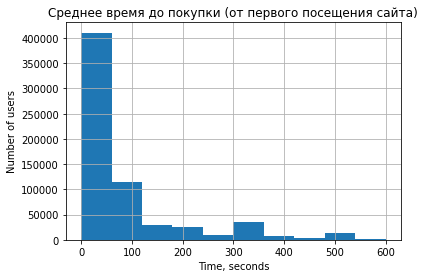

In [48]:
time_to_order = data['time_to_order'].hist(range = (0,600))

time_to_order.set_xlabel("Time, seconds")
time_to_order.set_ylabel("Number of users")
time_to_order.set_title("Среднее время до покупки (от первого посещения сайта)")

time_to_order

В 11% случаев время от первого посещения по покупки на сайте составляет 0 секунд. Предполагаю, что это значит, что покупка была совершена с какого-то сайта-агрегатора или переход с банера с кнопкой "Купить" - и сразу защитана как покупка, не смотря на то, что пользователь только что зашел на сайт.
В среднем же время от первого посещения до покупки составляет 423 часа или 17-18 дней.

##### - 2.2.2 Сколько раз покупают за период?

Сколько покупок делают пользователи за неделю / месяц?

Для нахождения кол-ва покупок за определенный период - нужно выделить этот период в данных.
Создадим в таблице orders отдельные столбцы: 

In [49]:
orders['order_year'] = orders['buy ts'].dt.year
orders['order_week'] = orders['buy ts'].dt.week
orders['order_month'] = orders['buy ts'].dt.month
orders['order_date'] = orders['buy ts'].dt.date
orders.head()

/Users/ulanovikova/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,buy ts,revenue,uid,first_order_date,order_year,order_week,order_month,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,22,6,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,22,6,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,22,6,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,22,6,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,22,6,2017-06-01


In [50]:
orders_per_day = orders.groupby(by = ['order_date'])['uid'].count()
orders_per_week = orders.groupby(by = ['order_year', 'order_week'])['uid'].count()
orders_per_month = orders.groupby(by = ['order_year', 'order_month'])['uid'].count()
orders_per_year = orders.groupby(by = ['order_year'])['uid'].count()

In [51]:
orders_per_week

order_year  order_week
2017        22             340
            23             938
            24             343
            25             371
            26             460
            27             477
            28             636
            29             716
            30             381
            31             314
            32             325
            33             392
            34             480
            35             588
            36             666
            37             668
            38             826
            39            1110
            40            1666
            41            1270
            42            1140
            43            1132
            44            1059
            45             919
            46            1257
            47            1894
            48            1387
            49            1520
            50            1388
            51            1184
            52            1620
2018        1   

<AxesSubplot:title={'center':'Кол-во заказов в неделю'}, xlabel='Кол-во заказов'>

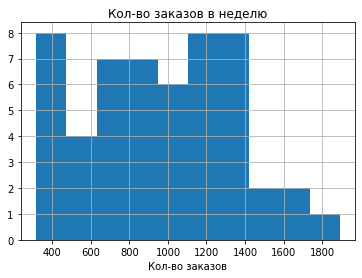

In [52]:
orders_per_week_hist = orders_per_week.hist()

orders_per_week_hist.set_xlabel("Кол-во заказов")
orders_per_week_hist.set_title("Кол-во заказов в неделю")

orders_per_week_hist

In [53]:
orders_per_day.describe()

count    364.000000
mean     138.502747
std       76.858480
min        1.000000
25%       82.750000
50%      136.000000
75%      177.000000
max      814.000000
Name: uid, dtype: float64

In [54]:
orders_per_week.describe()

count      53.000000
mean      951.226415
std       396.439958
min       314.000000
25%       636.000000
50%       991.000000
75%      1257.000000
max      1894.000000
Name: uid, dtype: float64

In [55]:
orders_per_week.mode()

0    890
dtype: int64

Text(0.5, 1.0, 'Количество заказов в неделю')

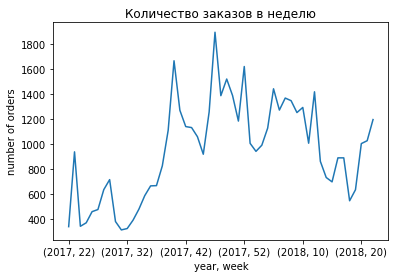

In [56]:
orders_per_week.plot()
plt.ylabel('number of orders')
plt.xlabel('year, week')
plt.title('Количество заказов в неделю')

In [57]:
orders_per_month

order_year  order_month
2017        6              2354
            7              2363
            8              1807
            9              3387
            10             5679
            11             5659
            12             6218
2018        1              4721
            2              5281
            3              5326
            4              3273
            5              4346
            6                 1
Name: uid, dtype: int64

In [58]:
orders_per_month.describe()

count      13.000000
mean     3878.076923
std      1858.113401
min         1.000000
25%      2363.000000
50%      4346.000000
75%      5326.000000
max      6218.000000
Name: uid, dtype: float64

Text(0.5, 1.0, 'Количество заказов в месяц')

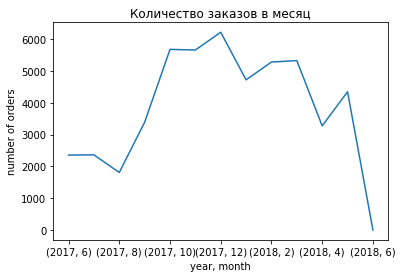

In [59]:
orders_per_month.plot()
plt.ylabel('number of orders')
plt.xlabel('year, month')
plt.title('Количество заказов в месяц')


In [60]:
orders_per_year

order_year
2017    27467
2018    22948
Name: uid, dtype: int64

Из рассмотренных данных видно, что:
- за рассмотренный отрезок в 2017 году было сделано 27467 покупок, а в 2018 - 22948.
- среднее кол-во покупок в месяц по всем когортам - 3878, оно колеблется от 2354 (в июне 2017) до 6218 (в декабре 2017) - видимо люди покупают подарки на новый год. В июне 2018 всего одна покупка (видимо попала в выборку случайно, тк мы смотрим данные до мая 2018).
- среднее кол-во заказов по всем когортам - 951(а наиболее встречающееся значение - 890), при этом наименьшее кол-во заказов в неделю было в июле 2017 - на 31ой неделе (314 заказов), а самое большое в конце ноября 2017 - на 47ой неделе(1894 заказов).

##### - 2.2.3 Какой средний чек?

Сколько в среднем тратят пользователи на один заказ?

In [61]:
avg_cost_per_order = orders['revenue'].mean()
avg_cost_per_order

4.999646930477041

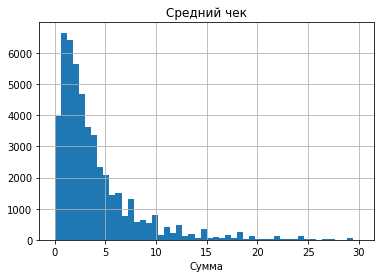

In [62]:
average_check_hist = orders['revenue'].hist(range = (0,30), bins = 50)

average_check_hist.set_xlabel("Сумма")
average_check_hist.set_title("Средний чек")

average_check_hist;

Посчитаем как меняется средний чек по когортам (по месяцам со дня первой покупки).

In [128]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month_filtered'] = orders['order_date'].astype('datetime64[M]')
orders.head()

,buy ts,revenue,uid,first_order_date,order_year,order_week,order_month,order_date,first_order_month,purchase_month,order_month_filtered
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,22,6,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,22,6,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,22,6,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,22,6,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,22,6,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [65]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month_filtered']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts

revenue   uid
first_order_month order_month_filtered                
2017-06-01        2017-06-01             9557.49  2023
                  2017-07-01              981.82    61
                  2017-08-01              885.34    50
                  2017-09-01             1931.30    54
                  2017-10-01             2068.58    88
...                                          ...   ...
2018-03-01        2018-05-01             1114.87    58
2018-04-01        2018-04-01            10600.69  2276
                  2018-05-01             1209.92    69
2018-05-01        2018-05-01            13925.76  2988
2018-06-01        2018-06-01                3.42     1

[79 rows x 2 columns]

In [66]:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts

revenue   uid  revenue_per_user
first_order_month order_month_filtered                                  
2017-06-01        2017-06-01             9557.49  2023          4.724414
                  2017-07-01              981.82    61         16.095410
                  2017-08-01              885.34    50         17.706800
                  2017-09-01             1931.30    54         35.764815
                  2017-10-01             2068.58    88         23.506591
...                                          ...   ...               ...
2018-03-01        2018-05-01             1114.87    58         19.221897
2018-04-01        2018-04-01            10600.69  2276          4.657597
                  2018-05-01             1209.92    69         17.535072
2018-05-01        2018-05-01            13925.76  2988          4.660562
2018-06-01        2018-06-01                3.42     1          3.420000

[79 rows x 3 columns]

In [67]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

Добавим столбец с временем жизни когорты:

In [129]:
orders_grouped_by_cohorts['order_lifetime'] = (orders_grouped_by_cohorts['order_month_filtered'] - orders_grouped_by_cohorts['first_order_month'])


orders_grouped_by_cohorts['order_lifetime'] = orders_grouped_by_cohorts['order_lifetime'] / np.timedelta64(1,'M')

orders_grouped_by_cohorts['order_lifetime'] = orders_grouped_by_cohorts['order_lifetime'].round().astype('int')

orders_grouped_by_cohorts

,first_order_month,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,58,19.221897,2
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0
76,2018-04-01,2018-05-01,1209.92,69,17.535072,1
77,2018-05-01,2018-05-01,13925.76,2988,4.660562,0


Построим сводную таблицу и посмотрим как изменяется средний чек с течением времени:

In [69]:
agerage_cost_per_order_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_lifetime',values='revenue_per_user',aggfunc='mean')
agerage_cost_per_order_pivot

order_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09-01,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10-01,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11-01,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


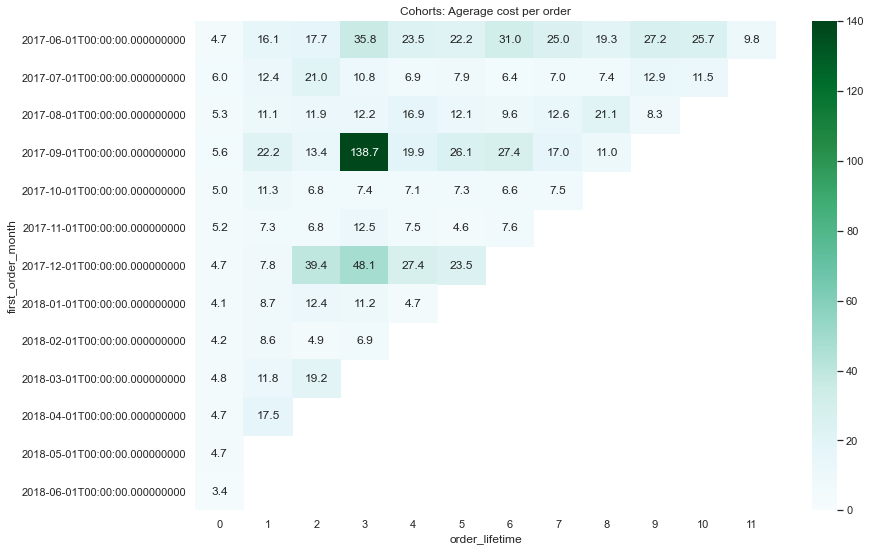

In [71]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: Agerage cost per order')

sns.heatmap(agerage_cost_per_order_pivot, annot=True,  fmt='.1f', vmin = 0,vmax = 140,cmap = 'BuGn');
plt.show()

In [73]:
orders_grouped_by_cohorts.loc[(orders_grouped_by_cohorts['first_order_month'] == '2017-09-01') & (orders_grouped_by_cohorts['order_month_filtered'] == '2017-12-01')]

,first_order_month,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime
36,2017-09-01,2017-12-01,10261.52,74,138.669189,3


In [74]:

orders.loc[(orders['first_order_month'] == '2017-09-01') & (orders['order_month_filtered'] == '2017-12-01')].agg({'uid': ['count','nunique']})

,uid
count,164
nunique,74


Text(0.5, 1.0, 'Кол-во и суммы заказов когорты с подозрительно большим средним чеком')

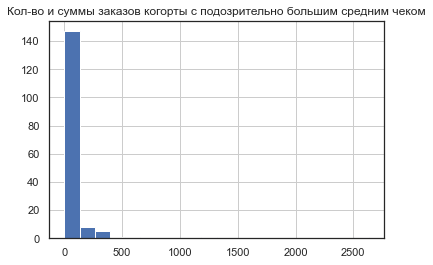

In [76]:
suspisious_orders = orders.loc[(orders['first_order_month'] == '2017-09-01') & (orders['order_month_filtered'] == '2017-12-01')]['revenue']
suspisious_orders_hist = suspisious_orders.hist(bins=20)

suspisious_orders_hist.set_title('Кол-во и суммы заказов когорты с подозрительно большим средним чеком')


In [77]:
suspisious_orders.max()

2633.28

Нашелся один очень большой заказ, видимо он-то и повлиял на сильное смещение среднего в большую сторону.

#### Из рассмотренных данных видно, что:

- Средний чек по всем кагортам равен 4.99.

- При этом средний чек из когорты в когорты довольно сильно меняется.

- Чаще всего средний чек растет с течением времени (хотя есть и исключения).

- Самые высокие средние чеки у когорты июня и декабря 2017 (36 и 48 соответственно).

- В декабре 2017 в сентябрьской когорте оказалось слишком большое значение среднего чека - 138.6, но при рассмотрении ближе оказалось, что один из заказов в этот период был очень большим (2633), он и сместил среднее в большую сторону.

##### - 2.2.4 Сколько денег приносят? (LTV)

LTV (lifetime value) — «пожизненная» ценность клиента или итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок.

Посчитаем LTV по когортам, используя таблицы orders, orders_grouped_by_cohorts и costs (чуть дальше также посчитаем LTV по устройствам и по источникам привлечения).

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

Выделим в таблице costs из даты месяц.

In [78]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


Посчитаем количество новых покупателей за каждый месяц:

In [79]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [80]:
orders_grouped_by_cohorts

,first_order_month,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,58,19.221897,2
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0
76,2018-04-01,2018-05-01,1209.92,69,17.535072,1
77,2018-05-01,2018-05-01,13925.76,2988,4.660562,0


Соединим таблицу orders_grouped_by_cohorts и данные о том сколько людей первый раз совершили покупку в каждый месяц (в таблице cohort_sizes):

In [81]:
report = pd.merge(cohort_sizes, orders_grouped_by_cohorts, on='first_order_month')
report

,first_order_month,n_buyers,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,58,19.221897,2
75,2018-04-01,2276,2018-04-01,10600.69,2276,4.657597,0
76,2018-04-01,2276,2018-05-01,1209.92,69,17.535072,1
77,2018-05-01,2988,2018-05-01,13925.76,2988,4.660562,0


LTV считают не из выручки, а из валовой прибыли. Валовую прибыль можно найти, умножив выручку на маржинальность (в данном случае она равна 1).

А также LTV — это относительный показатель, а значит его удобнее смотреть по «возрастным» когортам, где в столбцах — не месяц заказа, а возраст (age) когорты.

In [82]:
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month_filtered'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()

,first_order_month,n_buyers,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4,2068.58,4


Найдём LTV, для этого разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте.

#### Представим данные в виде сводной таблицы:

In [83]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


#### Также построим сводную таблицу с накопительным расчетом по длительности жизни:

In [84]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
output = output.cumsum(axis = 1)

    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


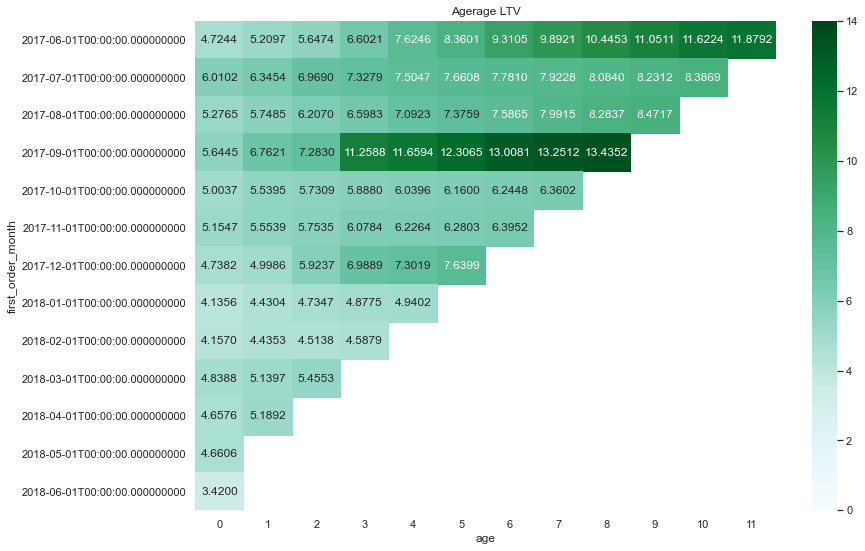

In [85]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Agerage LTV')

sns.heatmap(output, annot=True,  fmt='.4f', vmin = 0,vmax = 14,cmap = 'BuGn');
plt.show()

Посчитаем итоговый LTV первой когорты. Сложим их LTV по месяцам:

In [86]:
ltv_201706 = output.loc['2017-06-01'].sum()
ltv_201706

102.3689520514088

В среднем каждый покупатель из когорты июня 2017 года принес по 11.8 единиц выручки за 12 месяцев "жизни".

Из тепловой карты видно, что когорта сентября 2017 года была наиболее удачной - к 5-ому месяцу жизни она уже опережает по накопительному LTV когорту июня 2017 года, которая достигла таких показателей только к 10-11 месяцу жизни.

### 2.3 Маркетинг
- 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени
- 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?
- 2.3.3 На сколько окупились расходы? (ROI)

##### - 2.3.1 Сколько денег потратили? Всего / на каждый источник / по времени


Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

Если мы хотим посчитать сколько всего денег было потрачено на маркетинг нужно сложить данные столбца costs['costs'].

In [87]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [88]:
all_costs = costs['costs'].sum()
all_costs

329131.62

Всего на маркетинг было потрачено: 329131.62 единиц.
    

In [89]:
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})
costs_per_source

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


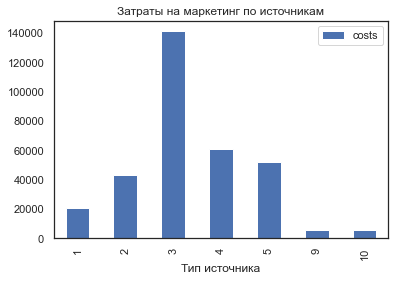

In [90]:
costs_per_source.plot(kind ='bar')

plt.title('Затраты на маркетинг по источникам')
plt.xlabel('Тип источника')
plt.show()

Больше всего денег на маркетинг было потрачено на 3 источник (141321.63 единиц). Примерно одинакого и меньше всего потратили на 9 и 10 источник (5517.49 и 5822.49 единиц соответственно).

In [91]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [92]:
costs_per_month = costs.groupby(['month','source_id']).agg({'costs': 'sum'})
costs_per_month

costs
month      source_id         
2017-06-01 1          1125.61
           2          2427.38
           3          7731.65
           4          3514.80
           5          2616.12
...                       ...
2018-05-01 3          9411.42
           4          4214.21
           5          3669.56
           9           362.17
           10          409.86

[84 rows x 1 columns]

In [93]:
costs_per_month.reset_index()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


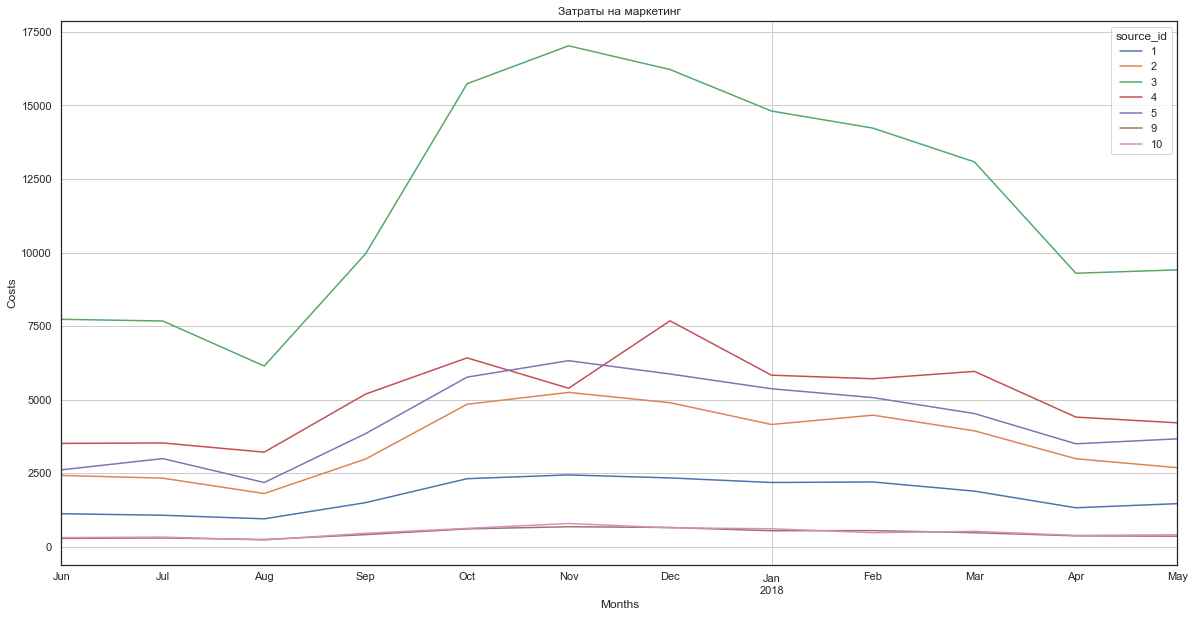

In [94]:
costs_per_month.pivot_table(index = ['month'], columns = 'source_id', values = 'costs', aggfunc = 'mean').plot(grid = True, figsize = (20, 10))
plt.title('Затраты на маркетинг')
plt.ylabel('Costs')
plt.xlabel('Months')
plt.show()

Из графика видно, что больше всего денег было потрачено на 3-ий источник в ноябре 2017 года, немного отстают от него октябрь и декабрь 2017, а меньше всего средств на 3-ий источник маркетинга было потрачено в августе 2017. В целом можно сказать, что 3-ий источник - самый затратный, тк даже в августе 2017 на него было потрачена почти максимальная сумма, затрачиваемая в любой другой месяц любого другого источника.

Наименее затратными являются 9-ый и 10-ый источник, траты на них практически не меняются с течением времени.


Что касается остальных источников - траты на них кажутся сезонными - летом тратится меньше, а в октябре - январе больше.

##### - 2.3.2 Сколько стоило привлечение одного покупателя из каждого источника?


<AxesSubplot:xlabel='month'>

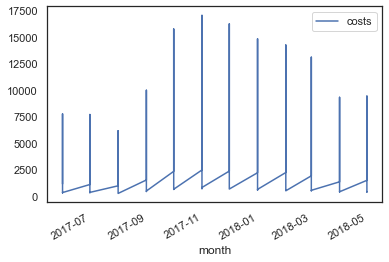

In [95]:
costs_per_month.reset_index().plot('month', 'costs', by = 'source_id')

 Для ответа на этот вопрос, построим профиль пользователя (мы считаем, что источник, через который первый раз пришел пользователь - и есть источник его привлечения, даже если пользователь купил что-то не в эту сессию, поэтому нас интересует источник, через который пользователь пришел во время своего первого посещения сайта):

In [96]:
users = (visits.sort_values(by = ['uid', 'start ts']).groupby('uid')
               .agg({'start ts' : 'first', 'source id': 'first', 'device': 'first'})
               .rename(columns = {'start ts' : 'acquisition_ts'}))
users

,acquisition_ts,source id,device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop
...,...,...,...
18446403737806311543,2017-11-30 03:36:00,5,desktop
18446424184725333426,2017-12-06 20:32:00,4,touch
18446556406699109058,2018-01-01 16:29:00,3,touch


In [97]:
users = users.rename(columns = {'source id': 'source_id'})
costs = costs.rename(columns = {'dt': 'acquisition_date'})

users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')

users = (users.reset_index().set_index(['source_id','acquisition_date'])
         .join(costs.set_index(['source_id','acquisition_date']), how = 'left'))
users

uid      acquisition_ts   device  \
source_id acquisition_date                                                      
1         2017-06-01          469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01          618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01         1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01         1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01         1548840741623289234 2017-06-01 01:18:00  desktop   
...                                          ...                 ...      ...   
10        2018-05-31        17550479715346067160 2018-05-31 22:00:00    touch   
          2018-05-31        17715613363403416471 2018-05-31 03:30:00  desktop   
          2018-05-31        18076428844159112818 2018-05-31 17:47:00    touch   
          2018-05-31        18238279803055794091 2018-05-31 15:52:00    touch   
          2018-05-31        18428797902626915731 2018-05-31 22:10:00  desktop   

                           acquisition_month  costs      month  
source_id acquisition_date                                      
1         2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01   75.2 2017-06-01  
...                                      ...    ...        ...  
10        2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  
          2018-05-31              2018-05-01   17.6 2018-05-01  

[228169 rows x 6 columns]

Теперь из этого профиля пользователя мы можем посчитать LTV, CAC и ROI по источникам и по устройствам, если нужно.

##### Посчитаем стоимость привлечения одного пользователя (CAC):

In [98]:
user_cost = (users.groupby(['source_id', 'acquisition_date']).agg({'device':'count', 'costs':'max'})
             .rename(columns = {'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how = 'left')
users = users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month',
                                              'source_id', 'device', 'acquisition_cost']]

users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


##### Посчитаем CAC (стомость привлечения одного покупателя) из каждого источника привлечения:

In [99]:
cac_per_source_id = users.groupby(by = 'source_id')['acquisition_cost'].mean()
cac_per_source_id

source_id
1     2.200388
2     2.429952
3     2.137480
4     0.844188
5     1.051169
6          NaN
7          NaN
9     0.845909
10    0.843274
Name: acquisition_cost, dtype: float64

<AxesSubplot:xlabel='source_id'>

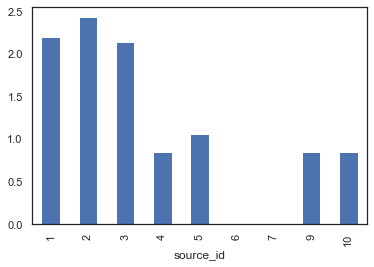

In [100]:
cac_per_source_id.plot.bar()

Из диаграммы видно, что больше всех стоит привлечение пользователя через 2ой тип источника,далее 1ый и 3ий, а меньше всего - через 4ый, 9ый и 10ый источник, в то время как 6ой и 7ой источник - бесплатные.

##### Также посчитаем CAC за каждый месяц.

In [102]:
cac_per_month_sum = users.groupby(by = 'acquisition_month')['acquisition_cost'].sum()
cac_per_month = users.groupby(by = 'acquisition_month')['acquisition_cost'].mean()
cac_per_month

acquisition_month
2017-06-01    1.358905
2017-07-01    1.387745
2017-08-01    1.452767
2017-09-01    1.458530
2017-10-01    1.398540
2017-11-01    1.391319
2017-12-01    1.516530
2018-01-01    1.481809
2018-02-01    1.473652
2018-03-01    1.477368
2018-04-01    1.417703
2018-05-01    1.455325
Name: acquisition_cost, dtype: float64

Теперь мы также можем посчитать LTV с разбивкой по источникам и устройствам.

Построим когорты по устройствам и найдем их размер:

In [131]:
users_by_device_count = (users.groupby(['device'])
                        .agg({'source_id': 'count'})
                        .rename(columns = {'source_id': 'cohort_size'}))
users_by_device_count

,cohort_size
device,
desktop,160795
touch,67374


In [104]:
orders.set_index('uid').join(users, how = 'left')

,buy ts,revenue,first_order_date,order_year,order_week,order_month,order_date,first_order_month,order_month_filtered,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost
uid,,,,,,,,,,,,,,,
9223707061355654945,2017-10-31 22:56:00,4.64,2017-10-31 22:56:00,2017,44,10,2017-10-31,2017-10-01,2017-10-01,2017-10-31 22:36:00,2017-10-31,2017-10-01,9,touch,1.907778
9224005701666002943,2017-12-26 11:15:00,3.36,2017-12-26 11:15:00,2017,52,12,2017-12-26,2017-12-01,2017-12-01,2017-12-26 11:11:00,2017-12-26,2017-12-01,5,desktop,0.981111
9224005701666002943,2018-03-16 17:11:00,3.67,2017-12-26 11:15:00,2018,11,3,2018-03-16,2017-12-01,2018-03-01,2017-12-26 11:11:00,2017-12-26,2017-12-01,5,desktop,0.981111
9225406053864431006,2017-12-28 16:29:00,0.43,2017-12-28 16:29:00,2017,52,12,2017-12-28,2017-12-01,2017-12-01,2017-09-28 18:47:00,2017-09-28,2017-09-01,4,desktop,1.433545
9225479525411867039,2018-02-25 16:54:00,7.33,2018-02-25 16:54:00,2018,8,2,2018-02-25,2018-02-01,2018-02-01,2018-02-25 16:46:00,2018-02-25,2018-02-01,4,touch,1.145752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9221059331469344216,2017-12-18 17:12:00,0.98,2017-12-18 17:12:00,2017,51,12,2017-12-18,2017-12-01,2017-12-01,2017-12-18 17:09:00,2017-12-18,2017-12-01,4,desktop,0.245661
9221809908447127809,2017-12-31 18:29:00,1.34,2017-12-31 18:29:00,2017,52,12,2017-12-31,2017-12-01,2017-12-01,2017-12-31 18:22:00,2017-12-31,2017-12-01,4,desktop,0.322606
9222179515197516675,2018-02-01 12:19:00,2.20,2018-02-01 12:19:00,2018,5,2,2018-02-01,2018-02-01,2018-02-01,2018-02-01 11:39:00,2018-02-01,2018-02-01,1,desktop,1.495286


In [105]:
orders = orders.rename(columns = {'order_month_filtered': 'purchase_month'})

ltv = orders.set_index('uid').join(users, how = 'left')[['acquisition_month', 'source_id', 'device','purchase_month', 'revenue']]
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')
ltv

,acquisition_month,source_id,device,purchase_month,revenue,age_month
uid,,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64,0
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36,0
9224005701666002943,2017-12-01,5,desktop,2018-03-01,3.67,3
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43,3
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33,0
...,...,...,...,...,...,...
9221059331469344216,2017-12-01,4,desktop,2017-12-01,0.98,0
9221809908447127809,2017-12-01,4,desktop,2017-12-01,1.34,0
9222179515197516675,2018-02-01,1,desktop,2018-02-01,2.20,0


##### Найдем LTV по устройствам:

In [106]:
ltv_by_device = ltv.groupby(['device'] + ['age_month']).agg({'revenue':'sum'})
ltv_by_device = pd.pivot_table(ltv_by_device,index = 'device', columns = 'age_month', values = 'revenue', aggfunc = 'sum')
ltv_by_device = ltv_by_device.cumsum(axis = 1)
ltv_by_device = users_by_device_count[['cohort_size']].join(ltv_by_device)
ltv_by_device = ltv_by_device.div(ltv_by_device['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv_by_device

,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.728664,0.843359,0.924280,1.069796,1.130539,1.182688,1.219687,1.246150,1.266860,1.288880,1.303720,1.314281
touch,0.373185,0.446775,0.478607,0.502507,0.521153,0.538848,0.551608,0.569115,0.583387,0.596858,0.601088,0.604498


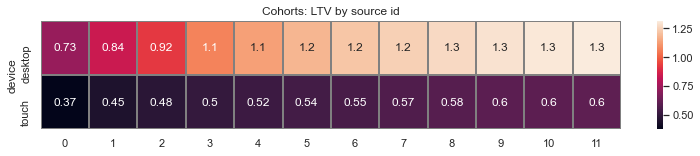

In [107]:
sns.set(style='white')
plt.figure(figsize=(13, 2))
plt.title('Cohorts: LTV by source id')
sns.heatmap(ltv_by_device, annot=True, linewidths=1, linecolor='gray');

Видим, что больше всех выручки приносят пользователи, пришедшие на сайт с desktop в 4 последних месяца выборки - с февраля по май 2018. А меньше всех принесли пользователи пришедшие на сайт с touch-устройств с июня по август 2017 года. Также видно, что в целом вырочка за пользователя, пришедшего с desktop - значительно выше во все месяцы.

Построим когорты устройствам и найдем их размер:

In [108]:
users_by_cohorts_sources = (users.groupby(['source_id'])
                        .agg({'device': 'count', 'acquisition_cost':'sum'})
                        .rename(columns = {'device': 'cohort_size'}))

##### Найдем LTV по источникам:

In [109]:
ltv_by_source = ltv.groupby(['source_id'] + ['age_month']).agg({'revenue':'sum'})
ltv_by_source = pd.pivot_table(ltv_by_source,index = 'source_id', columns = 'age_month', values = 'revenue', aggfunc = 'sum')
ltv_by_source = ltv_by_source.cumsum(axis = 1)
ltv_by_source = users_by_cohorts_sources[['cohort_size']].join(ltv_by_source)
ltv_by_source = ltv_by_source.div(ltv_by_source['cohort_size'], axis = 0).drop(columns = ['cohort_size'])
ltv_by_source

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.534161,1.810219,1.999839,2.288663,2.467350,2.585022,2.683702,2.916896,3.049194,3.141014,3.227996,3.283404
2,1.016428,1.360377,1.703597,2.072417,2.253705,2.394160,2.463452,2.507828,2.550502,2.604603,2.641813,2.663693
3,0.570372,0.659824,0.697257,0.731096,0.761171,0.782027,0.798246,0.807016,0.814781,0.819245,0.822212,0.824479
4,0.517687,0.579292,0.608671,0.637434,0.661811,0.691519,0.720278,0.730149,0.743284,0.762166,0.773152,0.783690
5,0.584571,0.654081,0.695008,0.915836,0.951518,0.995270,1.018674,1.037467,1.048500,1.064406,1.067149,1.068790
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.038125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.368263,0.466126,0.554842,0.633721,0.704563,0.739634,0.782604,0.813542,0.856348,0.881770,0.890800,0.893207
10,0.514917,0.558789,0.577229,0.588343,0.613280,0.624930,0.635299,0.639061,0.639681,0.642244,0.643377,0.644695


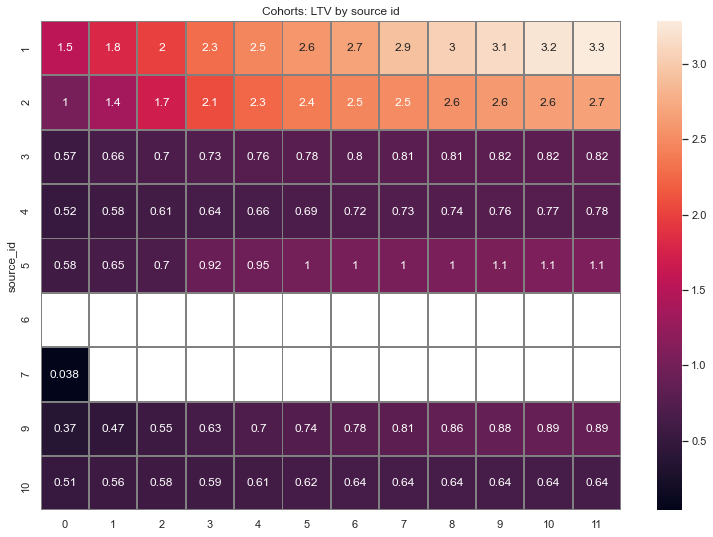

In [110]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV by source id')
sns.heatmap(ltv_by_source, annot=True, linewidths=1, linecolor='gray');

In [132]:
ltv_by_source_all_time = ltv.groupby(['source_id']).agg({'revenue':'sum'})
ltv_by_source_all_time

,revenue
source_id,
1,31090.55
2,46923.61
3,54511.24
4,56696.83
5,52624.02
7,1.22
9,5759.40
10,4450.33


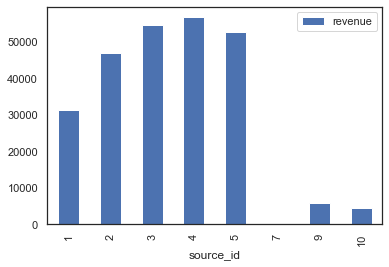

In [133]:
ltv_by_source_all_time.plot.bar();

Видим, что больше всех выручки приносят пользователи, пришедшие на сайт с 4ого, 3его и 5ого источника, а
самую низкую выручку приносят пользователи, пришедшие из 9ого и 10ого источника.
На маркетинг 6ого и 7ого источника мы ничего не тратим - но пользователи, пришедшие оттуда, ничего и не приносят.

##### - 2.3.3 На сколько окупились расходы? (ROI)

Создадим новую таблицу report_new:

In [113]:
cac_per_month_sum

acquisition_month
2017-06-01    18015.00
2017-07-01    18230.81
2017-08-01    14789.17
2017-09-01    24360.36
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38306.03
2018-01-01    33518.52
2018-02-01    32707.71
2018-03-01    30414.57
2018-04-01    22269.28
2018-05-01    22224.27
Name: acquisition_cost, dtype: float64

In [114]:
report

,first_order_month,n_buyers,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4,2068.58,4,1.022531
...,...,...,...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,58,19.221897,2,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,2276,4.657597,0,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,69,17.535072,1,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,2988,4.660562,0,13925.76,0,4.660562


In [116]:
report_new = report.join(cac_per_month_sum, on = 'first_order_month')
report_new['cac'] = report_new['acquisition_cost'] / report_new['n_buyers']
report_new

,first_order_month,n_buyers,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime,gp,age,ltv,acquisition_cost,cac
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0,9557.49,0,4.724414,18015.00,8.905091
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1,981.82,1,0.485329,18015.00,8.905091
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2,885.34,2,0.437637,18015.00,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3,1931.30,3,0.954671,18015.00,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4,2068.58,4,1.022531,18015.00,8.905091
...,...,...,...,...,...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,58,19.221897,2,1114.87,2,0.315559,30414.57,8.608709
75,2018-04-01,2276,2018-04-01,10600.69,2276,4.657597,0,10600.69,0,4.657597,22269.28,9.784394
76,2018-04-01,2276,2018-05-01,1209.92,69,17.535072,1,1209.92,1,0.531599,22269.28,9.784394
77,2018-05-01,2988,2018-05-01,13925.76,2988,4.660562,0,13925.76,0,4.660562,22224.27,7.437841


Посчитаем ROI для каждой строчки:

In [117]:
report_new['roi'] = report_new['ltv'] / report_new['cac']
report_new

,first_order_month,n_buyers,order_month_filtered,revenue,uid,revenue_per_user,order_lifetime,gp,age,ltv,acquisition_cost,cac,roi
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0,9557.49,0,4.724414,18015.00,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1,981.82,1,0.485329,18015.00,8.905091,0.054500
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2,885.34,2,0.437637,18015.00,8.905091,0.049145
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3,1931.30,3,0.954671,18015.00,8.905091,0.107205
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4,2068.58,4,1.022531,18015.00,8.905091,0.114825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,58,19.221897,2,1114.87,2,0.315559,30414.57,8.608709,0.036656
75,2018-04-01,2276,2018-04-01,10600.69,2276,4.657597,0,10600.69,0,4.657597,22269.28,9.784394,0.476023
76,2018-04-01,2276,2018-05-01,1209.92,69,17.535072,1,1209.92,1,0.531599,22269.28,9.784394,0.054331
77,2018-05-01,2988,2018-05-01,13925.76,2988,4.660562,0,13925.76,0,4.660562,22224.27,7.437841,0.626601


In [118]:
output_roi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='roi', 
        aggfunc='mean')

output_roi.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.74,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.24,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.50,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


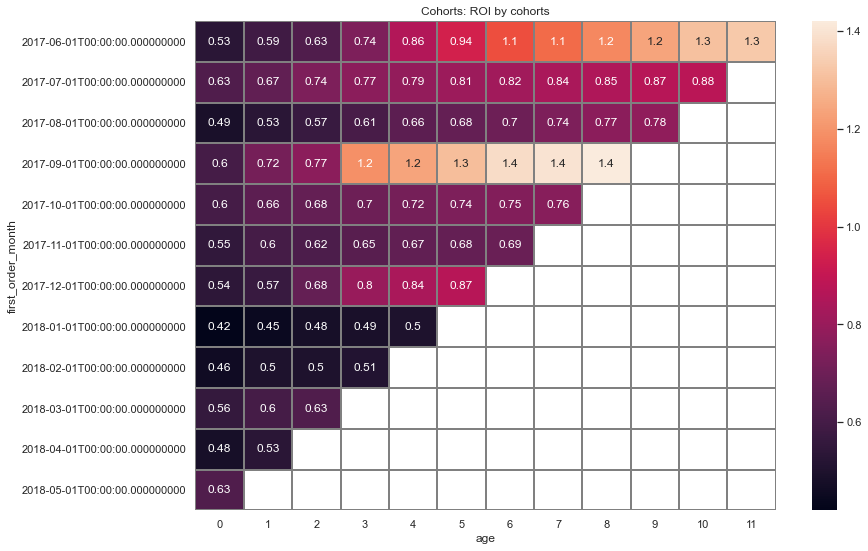

In [119]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: ROI by cohorts')
sns.heatmap(output_roi.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray');

Из таблицы видно, что раньше всех окупились пользователи когорты сентября 2017 и июня 2017 (это произошло на 3ий и на 6ой месяц соответственно). Остальные когорты двигаются к окупаемости сильно медленнее.

In [120]:
ltv

,acquisition_month,source_id,device,purchase_month,revenue,age_month
uid,,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64,0
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36,0
9224005701666002943,2017-12-01,5,desktop,2018-03-01,3.67,3
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43,3
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33,0
...,...,...,...,...,...,...
9221059331469344216,2017-12-01,4,desktop,2017-12-01,0.98,0
9221809908447127809,2017-12-01,4,desktop,2017-12-01,1.34,0
9222179515197516675,2018-02-01,1,desktop,2018-02-01,2.20,0


In [121]:
users_by_cohorts_sources

,cohort_size,acquisition_cost
source_id,,
1,9469,20833.27
2,17616,42806.04
3,66116,141321.63
4,72346,61073.60
5,49237,51756.40
6,2,0.00
7,32,0.00
9,6448,5454.42
10,6903,5821.12


In [122]:
ltv_by_source_new = ltv.groupby(['source_id'] + ['age_month']).agg({'revenue':'sum'})
ltv_by_source_new = ltv_by_source_new.join(users_by_cohorts_sources)
ltv_by_source_new['ltv'] = ltv_by_source_new['revenue'] / ltv_by_source_new['cohort_size']
ltv_by_source_new = ltv_by_source_new[['ltv']]
ltv_by_source_new

ltv
source_id age_month          
1         0          1.534161
          1          0.276058
          2          0.189621
          3          0.288824
          4          0.178687
...                       ...
10        7          0.003762
          8          0.000620
          9          0.002563
          10         0.001133
          11         0.001318

[85 rows x 1 columns]

In [123]:
cac_per_source_id

source_id
1     2.200388
2     2.429952
3     2.137480
4     0.844188
5     1.051169
6          NaN
7          NaN
9     0.845909
10    0.843274
Name: acquisition_cost, dtype: float64

In [124]:
roi_table = ltv_by_source_new.join(cac_per_source_id)
roi_table = roi_table.rename(columns={'acquisition_cost': 'cac'})
roi_table

ltv       cac
source_id age_month                    
1         0          1.534161  2.200388
          1          0.276058  2.200388
          2          0.189621  2.200388
          3          0.288824  2.200388
          4          0.178687  2.200388
...                       ...       ...
10        7          0.003762  0.843274
          8          0.000620  0.843274
          9          0.002563  0.843274
          10         0.001133  0.843274
          11         0.001318  0.843274

[85 rows x 2 columns]

In [125]:
roi_table['roi'] = roi_table['ltv'] / roi_table['cac']
roi_table

ltv       cac       roi
source_id age_month                              
1         0          1.534161  2.200388  0.697223
          1          0.276058  2.200388  0.125459
          2          0.189621  2.200388  0.086176
          3          0.288824  2.200388  0.131260
          4          0.178687  2.200388  0.081207
...                       ...       ...       ...
10        7          0.003762  0.843274  0.004461
          8          0.000620  0.843274  0.000735
          9          0.002563  0.843274  0.003039
          10         0.001133  0.843274  0.001343
          11         0.001318  0.843274  0.001563

[85 rows x 3 columns]

In [126]:
output_roi_by_source = roi_table.pivot_table(
        index='source_id', 
        columns='age_month', 
        values='roi', 
        aggfunc='mean')

output_roi_by_source.cumsum(axis=1).round(2) 

age_month,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.70,0.82,0.91,1.04,1.12,1.17,1.22,1.33,1.39,1.43,1.47,1.49
2,0.42,0.56,0.70,0.85,0.93,0.99,1.01,1.03,1.05,1.07,1.09,1.10
3,0.27,0.31,0.33,0.34,0.36,0.37,0.37,0.38,0.38,0.38,0.38,0.39
4,0.61,0.69,0.72,0.76,0.78,0.82,0.85,0.86,0.88,0.90,0.92,0.93
5,0.56,0.62,0.66,0.87,0.91,0.95,0.97,0.99,1.00,1.01,1.02,1.02
9,0.44,0.55,0.66,0.75,0.83,0.87,0.93,0.96,1.01,1.04,1.05,1.06
10,0.61,0.66,0.68,0.70,0.73,0.74,0.75,0.76,0.76,0.76,0.76,0.76


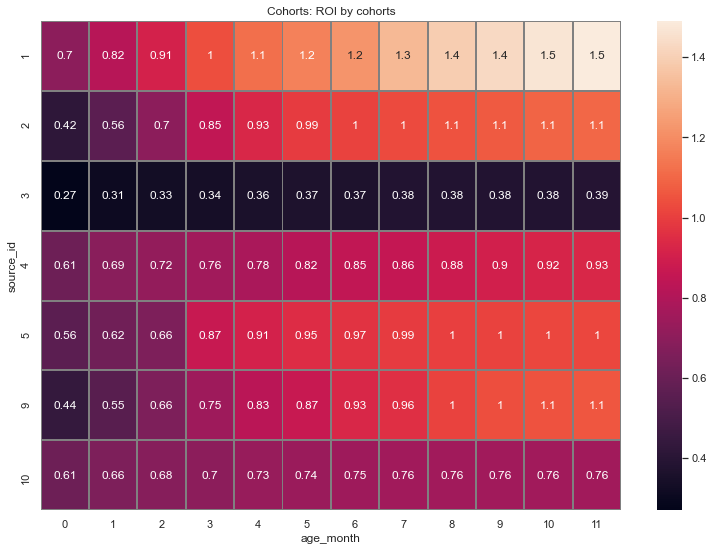

In [127]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: ROI by cohorts')
sns.heatmap(output_roi_by_source.cumsum(axis=1).round(2), annot=True, linewidths=1, linecolor='gray');

Если смотреть на ROI по источникам, то мы видим, что 1ый источник окупается через 3 месяца, 2ой через 6 месяцев, 5ый и 9ый к 8ому месяцу. 3ий источник очень далек от окупаемости даже через 11 месяцев. 4ый скорее всего окупится через примерно 14 месяцев, а 10ый - тоже далек от окупаемости к концу 11 месяца.

## Выводы <a class="anchor" id="fifth-bullet"></a>

В ходе проведенного анализа, были получены следующие данные:

1) В день продуктом в среднем пользуется 907 людей. В неделю - 5716 людей. В месяц - 23228 людей.

2) В среднем на одного пользователя приходится 1.087 сессий в день.

3) Большинство сессий длятся около минуты (но при этом есть очень длинные сессии, длящиеся больше часа).

4) Через месяц после первого посещения возвращается не больше 8,5% пользователей (сентябрь 2017). Коэффициент удержания пользователей чаще всего снижается от месяца к месяцу, но иногда немного растет. Когорта июня 2017 года изначально имела один из самых высоких коэффициентов удержания пользователей, но она также сохраняет его довольно высоким и через 11 месяцев (4,5%) - возможно стоит обратить внимание на то что было сделано в июне 2017 (или чуть раньше) для удержания пользователей - судя по всему это был удачный кейс.

5) В 11% случаев время от первого посещения по покупки на сайте составляет 0 секунд. Предполагаю, что это значит, что покупка была совершена с какого-то сайта-агрегатора или переход с банера с кнопкой "Купить" - и сразу защитана как покупка, не смотря на то, что пользователь только что зашел на сайт. В среднем же время от первого посещения до покупки составляет 423 часа или 17-18 дней.

6) За рассмотренный отрезок времни (с июня 2017 года по май 2018 года) в 2017 году было сделано 27467 покупок, а в 2018 - 22948. Среднее кол-во покупок в месяц по всем когортам - 3878, оно колеблется от 2354 (в июне 2017) до 6218 (в декабре 2017) - скорее всего потому что люди покупают подарки на новый год. В июне 2018 всего одна покупка (видимо попала в выборку случайно, тк мы смотрим данные до мая 2018). Среднее кол-во заказов по всем когортам - 951 (а наиболее встречающееся значение - 890), при этом наименьшее кол-во заказов в неделю было в июле 2017 - на 31ой неделе (314 заказов), а самое большое в конце ноября 2017 - на 47ой неделе (1894 заказов).

7) Средний чек по всем кагортам равен 4.99. При этом средний чек из когорты в когорты довольно сильно меняется. Чаще всего средний чек растет с течением времени (хотя есть и исключения). Самые высокие средние чеки у когорты июня и декабря 2017 (36 и 48 соответственно). В декабре 2017 в сентябрьской когорте оказалось слишком большое значение среднего чека - 138.6, но при рассмотрении ближе оказалось, что в этом месяце в сентябрьской когорте была только одна покупка, которая и сделала средний чек таким высоким.

8) В среднем каждый покупатель из когорты июня 2017 года принес по 11.8 единиц выручки за 12 месяцев "жизни".

9) Больше всех выручки приносят пользователи, пришедшие на сайт с 4ого, 3его и 5ого источника, а самую низкую выручку приносят пользователи, пришедшие из 9ого и 10ого источника. На маркетинг 6ого и 7ого источника мы ничего не тратим - но пользователи, пришедшие оттуда, ничего и не приносят.

10) Всего на маркетинг было потрачено: 329131.62 единиц. Больше всего денег на маркетинг было потрачено на 3 источник (141321.63 единиц). Примерно одинакого и меньше всего потратили на 9 и 10 источник (5517.49 и 5822.49 единиц соответственно). Из графика видно, что больше всего денег было потрачено в декабре 2017 года (38315.35 единиц), немного отстают от него октябрь и ноябрь 2017, а меньше всего средств было потрачено на маркетинг в августе 2017 (14790.54 единиц).

11) Больше всех стоит привлечение пользователя через 2ой тип источника,далее 1ый и 3ий, а меньше всего - через 4ый, 9ый и 10ый источник, в то время как 6ой и 7ой источник - бесплатные.

12) Раньше всех окупились пользователи когорты сентября 2017 и июня 2017 (это произошло на 3ий и на 6ой месяц соответственно). Остальные когорты двигаются к окупаемости сильно медленнее.
Если смотреть на ROI по источникам, то мы видим, что 1ый источник окупается через 3 месяца, 2ой через 6 месяцев, 5ый и 9ый к 8ому месяцу. 3ий источник очень далек от окупаемости даже через 11 месяцев. 4ый скорее всего окупится через примерно 14 месяцев, а 10ый - тоже далек от окупаемости к концу 11 месяца.

Исходя из проведенного анализа, смотря на ROI различных источников привлечения, мы видим, что в первую очередь стоит вкладываться в 1-ый источник, далее в приоритете 2-ой и потом 9-ый и 5-ый. 3-ий источник я бы не советовала использовать совсем, тк его окупаемость займет как минимум пару лет (если она вообще наступит).